In [1]:
from matplotlib.colors import ListedColormap
import matplotlib
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
import matplotlib as mpl
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from iofiles import *
from funcs import *

warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["font.family"] = 'Helvetica'
mpl.rcParams['font.serif'] = 'Helvetica'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def color(value):
    '''Convert RGB to colormaps ranging from 0 to 1.
    Input
    -----
      value : RGB colors.
    '''
    digit = list(map(str, range(10))) + list("ABCDEF")
    if isinstance(value, tuple):
        string = '#'
        for i in value:
            a1 = i // 16
            a2 = i % 16
            string += digit[a1] + digit[a2]
        return string
    elif isinstance(value, str):
        a1 = digit.index(value[1]) * 16 + digit.index(value[2])
        a2 = digit.index(value[3]) * 16 + digit.index(value[4])
        a3 = digit.index(value[5]) * 16 + digit.index(value[6])
    return (a1, a2, a3)


def shiftedColorMap(cmap, min_val, max_val, name):
    '''Function to offset the "center" of a colormap. Useful for data with a negative min and positive max and you want the middle of the colormap's dynamic range to be at zero. Adapted from https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

    Input
    -----
      cmap : The matplotlib colormap to be altered.
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.'''
    epsilon = 0.001
    start, stop = 0.0, 1.0
    min_val, max_val = min(0.0, min_val), max(0.0, max_val)  # Edit #2
    midpoint = 1.0 - max_val / (max_val + abs(min_val))
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([np.linspace(0.0,
                                         midpoint,
                                         128,
                                         endpoint=False),
                             np.linspace(midpoint,
                                         1.0,
                                         129,
                                         endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        if abs(si - midpoint) < epsilon:
            r, g, b, a = cmap(0.5)  # 0.5 = original midpoint.
        else:
            r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap

In [3]:
# initial the basic settings of the city
files = [['bj', '2019_402_284'], ['sh', '2015_431_320'], ['sz', '2017_376_248']]

[timeline, list_city, city_idx, city, city_abbr,
 G, G_relabeled, dualG, dual_nodes, dual_nodes_en, dual_edges,
 node_pos, node_pos_relabeled, line_pos
 ] = load_variable('src_data/initial_info_bj' + '.pkl')

city_abbr = files[city_idx][0]
suffix = files[city_idx][1]
snapshot = suffix[:4]

[matrix_Ss,
    matrix_nroutes,
    matrix_pathlength,
    matrix_pathdist,
    H_relabeled,
    dualH_sub,
    dualH_nodes_sub,
    dualH_edges_sub,
    N_sub,
    N_Ktot,
    matrix_S_nid,
    matrix_S_nid_C2,
    matrix_S_nid_C3,
 matrix_S_nid_C4] = load_variable('output/GSI/' + city_abbr + '_' + snapshot + '_card.pkl')


In [73]:
#     import the outputs
[matrix_matched_path] = load_variable(
    'output/matrix_matched_path_' + suffix + '.pkl')

list_df_matched_paths = []
list_df_Ss_i_j = []
for file in files:
    city_abbr = file[0]
    suffix = file[1]
    [df_matched_paths, df_Ss_i_j] = load_variable(
        'output/LSI/res_stationlevel_' + city_abbr + '_card_' + suffix + '.pkl')

    list_df_matched_paths.append(df_matched_paths)
    list_df_Ss_i_j.append(df_Ss_i_j)

In [5]:
# estimate flow on each subway line

dict_flow = {}
dict_flow_undirect = {}
for i in range(matrix_matched_path.shape[0]):
    for j in range(matrix_matched_path.shape[1]):
        if(i == j):
            continue
        if(matrix_matched_path[i][j] is not None):
            for idx in matrix_matched_path[i][j].index:
                list_stops_relabel = matrix_matched_path[i][j]['seq_stops'][idx]
                list_stops = [int(list_stops_relabel[k].split('-')[1]) for k in range(len(list_stops_relabel))
                              if k == 0 or list_stops_relabel[k].split('-')[1] != list_stops_relabel[k - 1].split('-')[1]]
                flows = matrix_matched_path[i][j]['avg_counts'][idx]
                for s in range(1, len(list_stops)):
                    if((list_stops[s - 1], list_stops[s]) in dict_flow):
                        dict_flow[(list_stops[s - 1], list_stops[s])] += flows
                    else:
                        dict_flow[(list_stops[s - 1], list_stops[s])] = flows
                    s1 = list_stops[s - 1] if list_stops[s -
                                                         1] <= list_stops[s] else list_stops[s]
                    s2 = list_stops[s] if list_stops[s -
                                                     1] <= list_stops[s] else list_stops[s - 1]
                    if((s1, s2) in dict_flow_undirect):
                        dict_flow_undirect[(s1, s2)] += flows
                    else:
                        dict_flow_undirect[(s1, s2)] = flows

dict_flow_all = dict_flow
dict_flow_undirect_all = dict_flow_undirect

edgelist = sorted([e for e in H_relabeled.edges if (int(e[0].split('-')[1]),
                                                    int(e[1].split('-')[1]))in dict_flow_undirect or (int(e[0].split('-')[1]),
                                                                                                      int(e[1].split('-')[1])) == (314,
                                                                                                                                   216)])
edgewidth = [dict_flow_undirect[(int(e[0].split('-')[1]), int(e[1].split('-')[1]))]
             if (int(e[0].split('-')[1]), int(e[1].split('-')[1]))in dict_flow_undirect
             else dict_flow_undirect[(int(e[1].split('-')[1]), int(e[0].split('-')[1]))]
             for e in edgelist]
nodesize = [max(
    [dict_flow_undirect[(int(node.split('-')[1]), int(adja.split('-')[1]))]
     if int(node.split('-')[1]) < int(adja.split('-')[1]) and
     (int(node.split('-')[1]), int(adja.split('-')[1]))in dict_flow_undirect
     else dict_flow_undirect[(int(adja.split('-')[1]), int(node.split('-')[1]))]
     if (int(adja.split('-')[1]), int(node.split('-')[1]))in dict_flow_undirect
     else 0
     for adja in H_relabeled[node]]) for node in H_relabeled.nodes]
nodesize = np.array(nodesize) / (max(edgewidth) / 60) + 1
edgewidth = np.array(edgewidth) / (max(edgewidth) / 13) + 0.5

(404514.0432313866, 484926.9243441125, 4382944.934219091, 4463357.815331818)

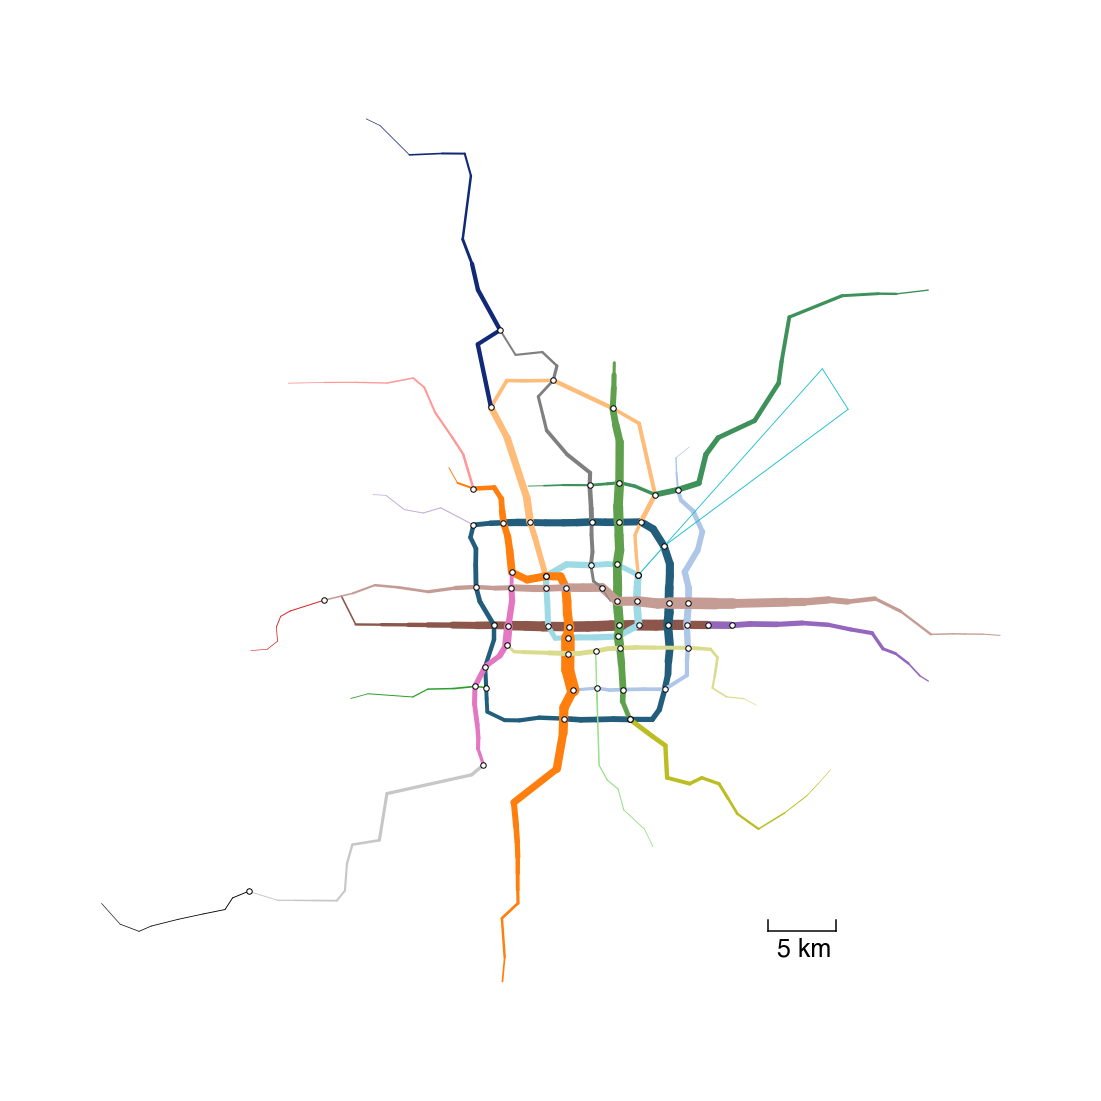

In [6]:
# generate the flow map

plt.figure(figsize=(20, 20))
[cgen] = load_variable('src_data/map_cgen.pkl')


nodes = nx.draw_networkx_nodes(
    G,
    pos=node_pos,
    node_size=30,
    node_color="white",
    edgecolors="black",
    linewidths=1,
    nodelist=[
        ex[2] for ex in dualH_edges_sub])

subedges = nx.draw_networkx_edges(G_relabeled,
                                  pos=node_pos_relabeled,
                                  node_size=0,
                                  arrowstyle="-",
                                  edge_color=[cgen[e[2] - 1] for e in edgelist],
                                  edge_cmap=plt.cm.tab20,
                                  edge_vmin=1,
                                  edge_vmax=25,
                                  width=edgewidth,
                                  edgelist=edgelist)


plt.gca().set_aspect('equal', adjustable='box')
x_center = plt.gca().get_xlim()
width = (x_center[1] - x_center[0]) / 2
x_center = (x_center[0] + x_center[1]) / 2
y_center = plt.gca().get_ylim()
y_center = (y_center[0] + y_center[1]) / 2


x_len = width
y_len = x_len
plt.xlim(x_center - x_len, x_center + x_len)
plt.ylim(y_center - y_len, y_center + y_len)
x1 = x_center + x_len / 2.5
x2 = x_center + x_len / 2.5 + 5000
y0 = y_center - y_len * 0.7
dy = 800
plt.plot([x1, x2], [y0, y0], 'black')
plt.plot([x1, x1], [y0, y0 + dy], 'black')
plt.plot([x2, x2], [y0, y0 + dy], 'black')
plt.annotate("5 km", xy=((x1 + x2) / 2, y0), xytext=(-25, -25),
             textcoords='offset points', fontsize=25)


plt.axis('off')

# plt.savefig('pic/flow.png',dpi=600)
# plt.savefig('pic/flow.svg',dpi=600)

(0.0, 1.0, 0.0, 1.0)

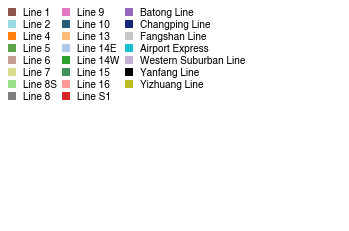

In [8]:
# generate the legend


[cgen] = load_variable('src_data/map_cgen.pkl')

patches = [mpatches.Patch(color=cgen[dual_nodes_en[n][0] - 1],
                          label="{:s}".format(dual_nodes_en[n][1]['name']),
                          alpha=1) for n in range(len(dual_nodes)) if dual_nodes[n] in dualH_nodes_sub]

plt.legend(
    handles=patches,
    ncol=3,
    fontsize=12,
    columnspacing=0.5,
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    handlelength=0.7,
    labelspacing=0.2,
    borderpad=0.1,
    prop={
        "family": "Helvetica"})  # 生成legend
plt.axis('off')

# plt.savefig('pic/legend.png',dpi=600)
# plt.savefig('pic/legend.svg',dpi=600)

In [51]:
name_stat = np.array(name_stat).astype(np.str_)
name_stat[name_stat  != 'None']

array(['地铁1号线', '地铁2号线', '地铁5号线', '地铁6号线', '地铁7号线', '地铁8号线', '地铁9号线',
       '地铁10号线', '地铁13号线', '地铁15号线', '地铁S1线', '地铁八通线', '地铁昌平线', '地铁房山线',
       '首都机场线', '地铁亦庄线'], dtype='<U6')

In [52]:
# Correlation between the estimated flow and the official released flow
df_matched_paths = list_df_matched_paths[0]
df_matched_paths = df_matched_paths.reset_index(drop=True)
arr_counts = np.array([0.0 for _ in dual_nodes])
for idx in df_matched_paths.index:
    seq = eval(df_matched_paths['seq_lines'][idx])
    if(seq != []):
        arr_counts[np.array(seq) - 1] += df_matched_paths['avg_counts'][idx]

# import the official released flow 
[dict_flow_stat] = load_variable('src_data/flow_official.pkl') #(2019/5/11 removed)

empirical_stat = [arr_counts[i] if dual_nodes[i][1]['name']
                  in dict_flow_stat else None for i in range(len(dual_nodes))]
empirical_stat = np.array(empirical_stat).astype(np.float64)
empirical_stat = empirical_stat[np.isnan(empirical_stat)==False]
empirical_stat = empirical_stat / sum(empirical_stat)

name_stat = [node[1]['name']if node[1]['name']
             in dict_flow_stat else None for node in dual_nodes]
name_stat = np.array(name_stat).astype(np.str_)
name_stat =  name_stat[name_stat  != 'None']

observe_stat = [sum(dict_flow_stat[node[1]['name']]) if node[1]
                ['name'] in dict_flow_stat else None for node in dual_nodes]
observe_stat = np.array(observe_stat).astype(np.float64)
observe_stat = observe_stat[np.isnan(observe_stat)==False]
observe_stat = observe_stat / sum(observe_stat)


# empirical_stat = empirical_stat.astype(np.float64)
observe_stat = observe_stat.astype(np.float64)

corr_stat = pd.DataFrame({'observation': empirical_stat * 100,
                          'estimation': observe_stat * 100,
                          'line': name_stat,
                          'snapshot': snapshot
                          })

model = LinearRegression()
model = model.fit(corr_stat[corr_stat['snapshot'] == snapshot]['estimation'].values.reshape(
    (-1, 1)), corr_stat[corr_stat['snapshot'] == snapshot]['observation'].values.reshape((-1, 1)))
'''get result
y = b0 + b1x
'''
r_sq = model.score(corr_stat[corr_stat['snapshot'] == snapshot]['estimation'].values.reshape(
    (-1, 1)), corr_stat[corr_stat['snapshot'] == snapshot]['observation'].values.reshape((-1, 1)))

print('coefficient of determination(𝑅²) : %.4f' % r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


coefficient of determination(𝑅²) : 0.9810
intercept: [-0.15567922]
slope: [[1.02490868]]


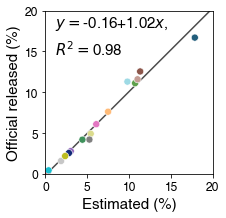

In [53]:
# regression plot

plt.figure(figsize=(3, 3))
snapshot = '2019'
[matrix_Ss,
    matrix_nroutes,
    matrix_pathlength,
    matrix_pathdist,
    H0,
    dualH_sub,
    dualH_nodes_sub,
    dualH_edges_sub,
    N_sub,
    N_Ktot,
    matrix_S_nid,
    matrix_S_nid_C2,
    matrix_S_nid_C3,
 matrix_S_nid_C4] = load_variable('output/GSI/bj_' + snapshot + '_card')

pt = sns.scatterplot(data=corr_stat[corr_stat['snapshot'] == snapshot], x='estimation', y='observation'  # ,label='2016  r = 0.997'
                     , hue='line', palette={n[1]['name']: cgen[n[0] - 1] for n in dualH_nodes_sub}, s=50, alpha=1, legend=False
                     )
pt.set_zorder(100)

x = np.arange(0, 21)
y = model.intercept_[0] + model.coef_[0][0] * x
l = plt.plot(x, y, 'black', alpha=0.7, zorder=-1)


plt.annotate('$y=$' +
             str(round(model.intercept_[0], 2)) +
             '+' + str(round(model.coef_[0][0], 2))
             + '$x$,\n',
             xy=(1, 14),

             #                  xytext = (-10,10),
             size=15,
             textcoords='offset points',
             #                  weight='bold'
             )

plt.annotate('$R^2=$' + str(round(r_sq, 2)),
             xy=(1, 13),
             size=15,
             textcoords='offset points',

             )


plt.xlabel('Estimated (%)', fontdict={"fontsize": 15})
plt.ylabel('Official released (%)', fontdict={"fontsize": 15})
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15, 20])
plt.xlim(0, 20)
plt.ylim(0, 20)

plt.tick_params(labelsize=12)
# plt.savefig('pic/correlation'+snapshot+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
# plt.savefig('pic/correlation'+snapshot+'.png',format = "png",dpi=600,transparent = True,bbox_inches = 'tight')



7
9
15
10
14
24
5
6
10


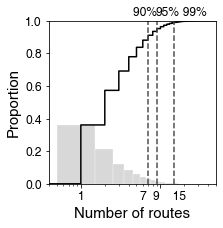

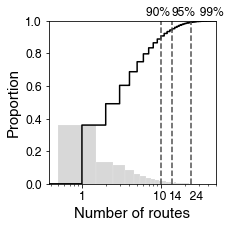

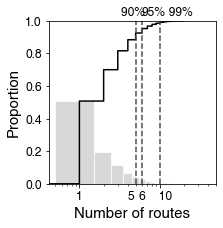

In [54]:
# The number of routes between stations

for i in range(len(list_df_Ss_i_j)):
    plt.figure(figsize=(3, 3))

    color1 = color((79, 79, 79))
    color2 = 'gray'
    color3 = 'black'

    df_Ss_i_j0 = list_df_Ss_i_j[i]
    sns.ecdfplot(
        data=df_Ss_i_j0,
        x='k_paths',
        y=None,
        hue=None,
        stat='proportion',
        label='station level',
        legend=True,
        ax=None,
        color=color3)

    sns.histplot(
        x='k_paths',
        data=df_Ss_i_j0,
        stat='probability',
        color=color2,
        edgecolor='white',
        discrete=True,
        alpha=0.3)

    perc_conf = 0.90
    for k in range(1, df_Ss_i_j0['k_paths'].max() + 1):
        if(len(df_Ss_i_j0[df_Ss_i_j0['k_paths'] <= k]) > len(df_Ss_i_j0['avg_counts']) * perc_conf):
            print(k)
            break

    plt.plot(np.array([k, k]), [0, 1], 'g--', color=color1)
    plt.annotate("%d%%      " % (perc_conf * 100), xy=(k, 1),
                 xytext=(-15, 5), textcoords='offset points', fontsize=12)
    plt.annotate("%d      " % (k), xy=(k, 0), xytext=(-8, -16),
                 textcoords='offset points', fontsize=12)

    perc_conf = 0.95
    for k in range(1, df_Ss_i_j0['k_paths'].max() + 1):
        if(len(df_Ss_i_j0[df_Ss_i_j0['k_paths'] <= k]) > len(df_Ss_i_j0['avg_counts']) * perc_conf):
            print(k)
            break

    plt.plot(np.array([k, k]), [0, 1], 'g--', color=color1)
    plt.annotate("%d%%" % (perc_conf * 100), xy=(k, 1),
                 xytext=(-1, 5), textcoords='offset points', fontsize=12)
    plt.annotate("%d" % (k), xy=(k, 0), xytext=(-4, -16),
                 textcoords='offset points', fontsize=12)

    perc_conf = 0.99
    for k in range(1, df_Ss_i_j0['k_paths'].max() + 1):
        if(len(df_Ss_i_j0[df_Ss_i_j0['k_paths'] <= k]) > len(df_Ss_i_j0['avg_counts']) * perc_conf):
            print(k)
            break

    plt.plot(np.array([k, k]), [0, perc_conf], 'g--', color=color1)
    xy = (k, perc_conf)
    plt.annotate("  %d%%" % (perc_conf * 100), xy=(k, 1),
                 xytext=(2, 5), textcoords='offset points', fontsize=12)
    plt.annotate("  %d" % (k), xy=(k, 0), xytext=(-8, -16),
                 textcoords='offset points', fontsize=12)

    ax = plt.gca()

    plt.ylabel('Proportion', fontdict={'font': 'Helvetica', "fontsize": 15})
    plt.xscale('log')
    plt.xlabel(
        'Number of routes',
        fontdict={
            "family": "Helvetica",
            "fontsize": 15})
    plt.tick_params(labelsize=12)

    plt.xlim(0, 50)
    label_vals = ax.get_xticklabels()
    label_vals[4] = str(100)
    label_vals[2] = str(1)
    r = ax.set_xticklabels(
        label_vals,
        fontdict={
            "fontsize": 12,
            'font': 'Helvetica'})

    plt.tick_params(labelsize=12)
    # plt.savefig('pic/k_ecdf'+snapshot+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
    # plt.savefig('pic/k_ecdf'+snapshot+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')


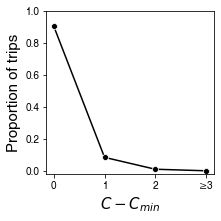

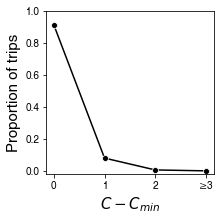

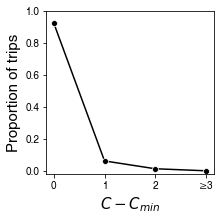

In [55]:
for i in range(len(list_df_matched_paths)):
    tmp = list_df_matched_paths[i].copy(deep=True)
    tmp['perc_all'] = tmp['avg_counts'] / tmp['avg_counts'].sum()
    tmp["diff_nroutes_sub"] = tmp["diff_nroutes_sub"].astype(int)
    tmp["${C - C_{min}}$"] = tmp["diff_nroutes_sub"]
    tmp["${C - C_{min}}$"][tmp["${C - C_{min}}$"] >= 3] = 3
    tmp["${C - C_{min}}$"] = tmp["${C - C_{min}}$"].astype(str)
    tmp["${C - C_{min}}$"][tmp["${C - C_{min}}$"] == '3'] = '≥3'

    plt.figure(figsize=(3, 3))

    sns.lineplot(
        data=tmp.groupby(
            by='${C - C_{min}}$',
            as_index=False).agg(
            {
                'perc_all': np.sum}),
        x='${C - C_{min}}$',
        y='perc_all',
        color='black',
        style=0,
        markers=True,
        legend=False)

    plt.xlabel(
        '${C - C_{min}}$',
        fontdict={
            "family": "Helvetica",
            "fontsize": 15})
    plt.ylabel(
        'Proportion of trips',
        fontdict={
            "family": "Helvetica",
            "fontsize": 15})
    plt.ylim(-0.02, 1)
    # plt.savefig('pic/k_C_'+snapshot+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
    # plt.savefig('pic/k_C_'+snapshot+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')
    # plt.savefig('pic/k_C_'+snapshot+'.eps',dpi=600,transparent = True,bbox_inches = 'tight')



In [78]:
    [
        matrix_Ss,
        matrix_nroutes,
        matrix_pathlength,
        matrix_pathdist,
        H0,
        dualH_sub,
        dualH_nodes_sub,
        dualH_edges_sub,
        N_sub,
        N_Ktot,
        matrix_S_nid,
        matrix_S_nid_C1,
        matrix_S_nid_C2,
        matrix_S_nid_C3] = load_variable(
        'output/GSI/' +
        city_abbr +
        '_' +
        snapshot +
        '_card' +
        '.pkl')
    
    df_Sij = pd.DataFrame()
    df_Sij['i'] = [i+1 for i in range(len(matrix_Ss)) for j in range(len(matrix_Ss[i]))]
    df_Sij['j'] = [j+1 for i in range(len(matrix_Ss)) for j in range(len(matrix_Ss[i]))]
    df_Sij['mindura'] = matrix_pathlength.flatten()
    df_Sij['S_const'] = matrix_Ss.flatten()
    df_Sij['minC'] = matrix_nroutes.flatten()-1

In [79]:
df_Sij

,i,j,mindura,S_const,minC
0,1,1,0.0,-0.0,0.0
1,1,2,1380.0,-0.0,0.0
2,1,3,660.0,-0.0,0.0
3,1,4,540.0,-0.0,0.0
4,1,5,1200.0,-0.0,0.0
...,...,...,...,...,...
115595,340,336,1080.0,-0.0,0.0
115596,340,337,480.0,-0.0,0.0
115597,340,338,1860.0,-0.0,0.0
115598,340,339,960.0,-0.0,0.0


In [80]:
# Combine the results of GSI and LSI

list_df_Sst = []
for i in range(len(list_df_matched_paths)):
    df_Ss_i_j = list_df_Ss_i_j[i]
    df_matched_paths = list_df_matched_paths[i]

    file = files[i]
    city_abbr = file[0]
    suffix = file[1]
    snapshot = suffix[:4]

    df_Sst = pd.DataFrame()

    [timeline,
     list_city,
     city_idx,
     city,
     city_abbr,
     G,
     G_relabeled,
     dualG,
     dual_nodes,
     dual_nodes_en,
     dual_edges,
     node_pos,
     node_pos_relabeled,
     line_pos] = load_variable('src_data/initial_info_' + city_abbr + '.pkl')

    [
        matrix_Ss,
        matrix_nroutes,
        matrix_pathlength,
        matrix_pathdist,
        H0,
        dualH_sub,
        dualH_nodes_sub,
        dualH_edges_sub,
        N_sub,
        N_Ktot,
        matrix_S_nid,
        matrix_S_nid_C1,
        matrix_S_nid_C2,
        matrix_S_nid_C3] = load_variable(
        'output/GSI/' +
        city_abbr +
        '_' +
        snapshot +
        '_card' +
        '.pkl')
    
    df_Sij = pd.DataFrame()
    df_Sij['i'] = [i+1 for i in range(len(matrix_Ss)) for j in range(len(matrix_Ss[i]))]
    df_Sij['j'] = [j+1 for i in range(len(matrix_Ss)) for j in range(len(matrix_Ss[i]))]
    df_Sij['mindura'] = matrix_pathlength.flatten()
    df_Sij['S_const'] = matrix_Ss.flatten()
    df_Sij['minC'] = matrix_nroutes.flatten()-1

    df_Sst['i'] = [i + 1 for i in range(len(matrix_S_nid))
                   for j in range(len(matrix_S_nid[i]))]
    df_Sst['j'] = [j + 1 for i in range(len(matrix_S_nid))
                   for j in range(len(matrix_S_nid[i]))]

    k = '∞'
    df_Sst[k] = matrix_S_nid.flatten()
    df_Sst[k + '-1'] = matrix_S_nid_C1.flatten()
    df_Sst[k + '-2'] = matrix_S_nid_C2.flatten()
    df_Sst[k + '-3'] = matrix_S_nid_C3.flatten()

    [matrix_S_nid,
     matrix_S_nid_C1,
     matrix_S_nid_C2,
     matrix_S_nid_C3,
     ] = load_variable('output/LSI/res_linelevel_card_' + suffix + '.pkl')
    k = 'obs'
    df_Sst[k] = matrix_S_nid.flatten()
    df_Sst[k + '-1'] = matrix_S_nid_C1.flatten()
    df_Sst[k + '-2'] = matrix_S_nid_C2.flatten()
    df_Sst[k + '-3'] = matrix_S_nid_C3.flatten()

    minC = get_matrixC(dualH_sub, dualH_nodes_sub,
                       max([node for node in dualG]))
    df_Sst['Cmin'] = minC.flatten()

#     matrix_C = merge_2_st_matching_C(H0,df_matched_paths,max([node for node in dualG]),count_weighted=True)
    matrix_C = merge_2_st_matching_C(H0, df_matched_paths, max(
        [node for node in dualG]), count_weighted=True)

    df_Sst['C'] = matrix_C.flatten()

    df_Sst['C_i'] = df_Sst['C'] + 0.5
    df_Sst.loc[np.isnan(df_Sst['C_i']) == False, 'C_i'] = df_Sst[np.isnan(
        df_Sst['C_i']) == False]['C_i'].astype(np.int)

#     df_Ss_i_j['duration'] /= 60
    df_Ss_i_j['nroutes'] -= 1
    df_Ss_i_j['min_nroutes'] -= 1
    df_Ss_i_j = df_Ss_i_j.merge(df_Sij, on=['i', 'j'])
    df_Ss_i_j['mindura'] /= 60
    list_df_Ss_i_j[i] = df_Ss_i_j
    list_df_Sst.append(df_Sst)


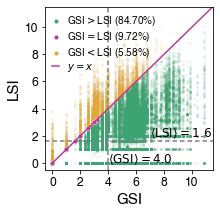

In [82]:
plt.figure(figsize=(3, 3))

df_Ss_i_j0 = list_df_Ss_i_j[0]

color1 = color((61, 163, 114))
color2 = color((227, 167, 53))
color3 = color((180, 62, 148))

g0 = sns.scatterplot(
    # [(df_Ss_i_j0['class']==1)&(df_Ss_i_j0['avg_counts']>np.percentile(df_Ss_i_j0['avg_counts'],0))],#df_Ss_i_j0[df_Ss_i_j0['avg_counts']>np.percentile(df_Ss_i_j0['avg_counts'],98)],
    data=df_Ss_i_j0[(df_Ss_i_j0['S_const'] > df_Ss_i_j0['S_sub'])], x='S_const', y='S_sub', s=5, color=color1, alpha=0.1, edgecolor=None, legend=False
)
g0 = sns.scatterplot(data=df_Ss_i_j0[(df_Ss_i_j0['S_const'] < df_Ss_i_j0['S_sub'])],
                     x='S_const', y='S_sub', s=5, color=color2, alpha=0.1, edgecolor=None, legend=False)
g0 = sns.scatterplot(data=df_Ss_i_j0[(df_Ss_i_j0['S_const'] == df_Ss_i_j0['S_sub'])],
                     x='S_const', y='S_sub', s=20, color=color3, legend=False)
g0 = sns.scatterplot(x=[-1], y=[-1], label=r'GSI$>$LSI (%.2f%%)' % (len(df_Ss_i_j0[(
    df_Ss_i_j0['S_const'] > df_Ss_i_j0['S_sub'])]) / len(df_Ss_i_j0) * 100), s=20, color=color1)
g0 = sns.scatterplot(x=[-1], y=[-1], label=r'GSI$=$LSI (%.2f%%)' % (len(df_Ss_i_j0[(
    df_Ss_i_j0['S_const'] == df_Ss_i_j0['S_sub'])]) / len(df_Ss_i_j0) * 100), s=20, color=color3)
g0 = sns.scatterplot(x=[-1], y=[-1], label=r'GSI$<$LSI (%.2f%%)' % (len(df_Ss_i_j0[(
    df_Ss_i_j0['S_const'] < df_Ss_i_j0['S_sub'])]) / len(df_Ss_i_j0) * 100), s=20, color=color2)

sns.lineplot([0, 11.5], [0, 11.5], color=color3, label='$y=x$', legend=False
             )
plt.axvline(
    x=np.average(
        df_Ss_i_j0['S_const']), color='gray', dashes=(
            3, 2), zorder=1)
plt.axhline(
    y=np.average(
        df_Ss_i_j0['S_sub']), color='gray', dashes=(
            3, 2), zorder=1)
ax = plt.gca()

h, l = ax.get_legend_handles_labels()
plt.legend([h[1],
            h[2],
            h[3],
            h[0]],
           [l[1],
            l[2],
            l[3],
            l[0]],
           borderaxespad=0.2,
           frameon=False,
           handlelength=0.7,
           labelspacing=0.2,
           borderpad=0.5,
           fontsize=10,
           loc='upper left')

plt.annotate(
    r"$\langle \rm{LSI}\rangle=%.1f $" %
    np.average(
        df_Ss_i_j0['S_sub']), xy=(
            7, np.average(
                df_Ss_i_j0['S_sub']) + 0.3), xytext=(
                    0, 0), textcoords='offset points', fontsize=12)
plt.annotate(
    r"$\langle \rm{GSI}\rangle=%.1f $" %
    np.average(
        df_Ss_i_j0['S_const']), xy=(
            np.average(
                df_Ss_i_j0['S_const']), 0), xytext=(
                    0, 0), textcoords='offset points', fontsize=12)

ax.set_xlim(-0.5, 11.5)
ax.set_ylim(-0.5, 11.5)
ax.set_xlabel(xlabel='GSI', fontdict={"family": "Helvetica", "fontsize": 15})
ax.set_ylabel(ylabel='LSI', fontdict={"family": "Helvetica", "fontsize": 15})
ax.set_xticks([0, 2, 4, 6, 8, 10])
plt.tick_params(labelsize=12)

picname = 'pic/GSI_LSI_Ss'
# plt.savefig(picname+'.svg',format = "svg",dpi=100,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.png',format = "png",dpi=600,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.eps',format = "eps",dpi=600,transparent = True,bbox_inches = 'tight')


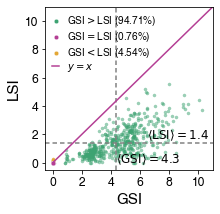

In [83]:
plt.figure(figsize=(3, 3))

df_Sst = list_df_Sst[0]

g0 = sns.scatterplot(data=df_Sst[(df_Sst['∞'] > df_Sst['obs'])],
                     x='∞',
                     y='obs',
                     s=10,
                     color=color1,
                     alpha=0.5,
                     edgecolor=None,
                     legend=False)
g0 = sns.scatterplot(data=df_Sst[(df_Sst['∞'] < df_Sst['obs'])],
                     x='∞',
                     y='obs',
                     color=color2,
                     s=10,
                     alpha=0.5,
                     edgecolor=None,
                     legend=False)
g0 = sns.scatterplot(data=df_Sst[(
    df_Sst['∞'] == df_Sst['obs'])], x='∞', y='obs', s=20, color=color3, legend=False)

g0 = sns.scatterplot(x=[-1], y=[-1], label=r'GSI$>$LSI (%.2f%%)' % (len(df_Sst[(df_Sst['∞'] >
                                                                                df_Sst['obs'])]) / len(df_Sst[np.isnan(df_Sst['obs']) != True]) * 100), s=20, color=color1)
g0 = sns.scatterplot(x=[-1], y=[-1], label=r'GSI$=$LSI (%.2f%%)' % (len(df_Sst[(df_Sst['∞'] ==
                                                                                df_Sst['obs'])]) / len(df_Sst[np.isnan(df_Sst['obs']) != True]) * 100), s=20, color=color3)
g0 = sns.scatterplot(x=[-1], y=[-1], label=r'GSI$<$LSI (%.2f%%)' % (len(df_Sst[(df_Sst['∞'] <
                                                                                df_Sst['obs'])]) / len(df_Sst[np.isnan(df_Sst['obs']) != True]) * 100), s=20, color=color2)


sns.lineplot([0, 11.5], [0, 11.5], color=color3, label='$y=x$')
ax.set_xlim(0, 12)
plt.axvline(x=np.nanmean(df_Sst[np.isnan(
    df_Sst['∞']) == False]['∞']), color='gray', dashes=(3, 2), zorder=1)
plt.axhline(y=np.nanmean(df_Sst[np.isnan(
    df_Sst['∞']) == False]['obs']), color='gray', dashes=(3, 2), zorder=1)
ax = plt.gca()
ax.set_xlim(-0.5, 11)
ax.set_ylim(-0.5, 11)

h, l = ax.get_legend_handles_labels()
plt.legend(
    #     h,l
    [h[1], h[2], h[3], h[0]], [l[1], l[2], l[3], l[0]], borderaxespad=0.2, frameon=False, handlelength=0.7, labelspacing=0.2, borderpad=0.5, fontsize=10, loc='upper left'
    #            ,prop={"family" : "Helvetica"}
)

plt.annotate(r"$\langle \rm{LSI}\rangle=%.1f $" % np.nanmean(df_Sst[np.isnan(df_Sst['∞']) == False]['obs']), xy=(
    6.5, np.nanmean(df_Sst[np.isnan(df_Sst['∞']) == False]['obs']) + 0.3), xytext=(0, 0), textcoords='offset points', fontsize=12)
plt.annotate(r"$\langle \rm{GSI}\rangle=%.1f $" % np.nanmean(df_Sst[np.isnan(df_Sst['∞']) == False]['∞']), xy=(
    np.nanmean(df_Sst[np.isnan(df_Sst['∞']) == False]['∞']), 0), xytext=(0, 0), textcoords='offset points', fontsize=12)

ax.set_xlabel(xlabel='GSI', fontdict={"family": "Helvetica", "fontsize": 15})
ax.set_ylabel(ylabel='LSI', fontdict={"family": "Helvetica", "fontsize": 15})
ax.set_xticks([0, 2, 4, 6, 8, 10])

plt.tick_params(labelsize=12)

picname = 'pic/GSI_LSI_Sl'
# plt.savefig(picname+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.eps',format = "eps",dpi=600,transparent = True,bbox_inches = 'tight')



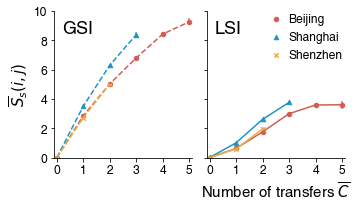

In [81]:
fig = plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
list_color = [
    color((209, 92, 83)),
    color((30, 147, 201)),
    color((235, 175, 70))]

for i in range(3):
    df_Ss_i_j = list_df_Ss_i_j[i]
    file = files[i]
    city_abbr = file[0]
    suffix = file[1]
    snapshot = suffix[:4]

    df_Ss_i_j0 = df_Ss_i_j.copy(deep=True)
    diameter = df_Ss_i_j0['minC'].max()

    df_Ss_i_j0['nroutes_i'] = df_Ss_i_j0['nroutes'] + 0.5
    df_Ss_i_j0['nroutes_i'] = np.int64(df_Ss_i_j0['nroutes_i'])
    df_Ss_i_j0 = df_Ss_i_j0[df_Ss_i_j0['nroutes_i'] <= diameter]

    markers = ['o', '^', 'x']
    ax = plt.scatter(
        x=df_Ss_i_j0.groupby(by=['minC'], as_index=False).aggregate({'S_const': np.average, 'S_sub': np.average})['minC'], y=df_Ss_i_j0.groupby(
            by=['minC'], as_index=False).aggregate({'S_const': np.average, 'S_sub': np.average})['S_const'], color=list_color[i]  # 'black'
        , s=20, marker=markers[i]
    )
    ax = sns.lineplot(
        # .groupby(by=['minC']).aggregate({'S_const':np.average,'S_sub':np.average})
        # 'black'
        data=df_Ss_i_j0, x='minC', y='S_const', label='GSI', color=list_color[i], ci=95, err_style='bars', linestyle='--', legend=False

    )

plt.ylabel(
    r'$\overline{ S}_s(i,j) $',
    fontdict={
        "family": "Helvetica",
        "fontsize": 15})
plt.tick_params(labelsize=12)

plt.xlabel(r'Number of transfers $\overline{C}$', fontdict={"fontsize": 15})
plt.ylim(0, 10)
plt.xlim(-0.1, 5.1)

plt.gca().set_xticks([0, 1, 2, 3, 4, 5])

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(None)
plt.annotate(
    "GSI", xy=(
        0, 8.5), xytext=(
            5, 0), textcoords='offset points', fontsize=18)


plt.subplot(1, 2, 2)
for i in range(3):
    df_Ss_i_j = list_df_Ss_i_j[i]
    file = files[i]
    city_abbr = file[0]
    suffix = file[1]
    snapshot = suffix[:4]

    df_Ss_i_j0 = df_Ss_i_j.copy(deep=True)
    diameter = df_Ss_i_j0['minC'].max()

    df_Ss_i_j0['nroutes_i'] = df_Ss_i_j0['nroutes'] + 0.5
    df_Ss_i_j0['nroutes_i'] = np.int64(df_Ss_i_j0['nroutes_i'])
    df_Ss_i_j0 = df_Ss_i_j0[df_Ss_i_j0['nroutes_i'] <= diameter]

    ax = plt.scatter(
        x=df_Ss_i_j0.groupby(
            by=['nroutes_i'], as_index=False).aggregate(
            {
                'S_const': np.average, 'S_sub': np.average})['nroutes_i'], y=df_Ss_i_j0.groupby(
                by=['nroutes_i'], as_index=False).aggregate(
                    {
                        'S_const': np.average, 'S_sub': np.average})['S_sub'], color=list_color[i]  # 'black'
        , s=20, marker=markers[i], label=city_abbr
    )

    sns.lineplot(
        # 'black'
        data=df_Ss_i_j0, x='nroutes_i', y='S_sub', color=list_color[i], ci=95, err_style='bars', markers=False, legend=False
    )


plt.ylabel(None)
plt.tick_params(labelsize=12)
plt.xlabel(None)
plt.xlabel(r'Number of transfers $\overline{C}$', fontdict={"fontsize": 15})
# plt.axvline(x = int(8/intv),dashes=(2,2))
plt.ylim(0, 10)
plt.xlim(-0.1, 5.1)


plt.gca().set_xticks([0, 1, 2, 3, 4, 5])
ax = plt.gca()
plt.legend()
h, l = ax.get_legend_handles_labels()
l = ['Beijing', 'Shanghai', 'Shenzhen']
plt.legend(
    h,
    l,
    borderaxespad=0.2,
    frameon=False,
    handlelength=0.5,
    borderpad=0,
    fontsize=12,
    loc='upper right')

# xticks = np.array(range(-1,200,10))
# xlabels = np.array(range(-1,200,10))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
plt.annotate(
    "LSI", xy=(
        0, 8.5), xytext=(
            5, 0), textcoords='offset points', fontsize=18)

plt.tight_layout()

picname = 'pic/C_Ss_' + 'cities'
# plt.savefig(picname+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.eps',format = "eps",dpi=600,transparent = True,bbox_inches = 'tight')


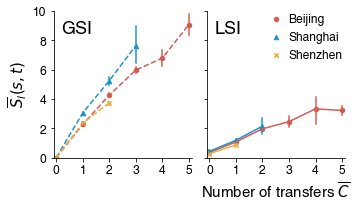

In [84]:
fig = plt.figure(figsize=(5., 3))
plt.subplot(1, 2, 1)
list_color = [
    color((209, 92, 83)),
    color((30, 147, 201)),
    color((235, 175, 70))]

for i in range(3):
    df_Ss_i_j = list_df_Ss_i_j[i]
    file = files[i]
    city_abbr = file[0]
    suffix = file[1]
    snapshot = suffix[:4]
    df_Sst = list_df_Sst[i]
    diameter = df_Sst['Cmin'].max()
    df_Sst = df_Sst[df_Sst['C_i'] <= diameter]

    markers = ['o', '^', 'x']
    ax = plt.scatter(
        x=df_Sst[np.isnan(df_Sst['∞']) == False].groupby(by=['Cmin'], as_index=False).aggregate({'∞': np.average})['Cmin'], y=df_Sst[np.isnan(
            df_Sst['∞']) == False].groupby(by=['Cmin'], as_index=False).aggregate({'∞': np.average})['∞'], color=list_color[i]  # 'black'

        , s=20, marker=markers[i]
    )

    ax = sns.lineplot(data=df_Sst[np.isnan(df_Sst['∞']) == False],
                      x='Cmin',
                      y='∞',
                      err_style='bars',
                      ci=95,
                      color=list_color[i],
                      legend=False,
                      linestyle='--')

plt.ylabel(
    r'$\overline{ S}_l(s,t)  $',
    fontdict={
        "family": "Helvetica",
        "fontsize": 15})
plt.tick_params(labelsize=12)

plt.xlabel(r'Number of transfers $\overline{C}$', fontdict={"fontsize": 15})
plt.ylim(0, 10)
plt.xlim(-0.1, 5.1)

plt.gca().set_xticks([0, 1, 2, 3, 4, 5])

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(None)
plt.annotate(
    "GSI", xy=(
        0, 8.5), xytext=(
            5, 0), textcoords='offset points', fontsize=18)

plt.subplot(1, 2, 2)
for i in range(3):
    df_Ss_i_j = list_df_Ss_i_j[i]
    file = files[i]
    city_abbr = file[0]
    suffix = file[1]
    snapshot = suffix[:4]
    df_Sst = list_df_Sst[i]
    diameter = df_Sst['Cmin'].max()
    df_Sst = df_Sst[df_Sst['C_i'] <= diameter]

    ax = plt.scatter(
        x=df_Sst[np.isnan(df_Sst['∞']) == False].groupby(by=['C_i'], as_index=False).aggregate({'obs': np.average})['C_i'], y=df_Sst[np.isnan(
            df_Sst['∞']) == False].groupby(by=['C_i'], as_index=False).aggregate({'obs': np.average})['obs'], label=city_abbr, color=list_color[i]  # 'black'
        , marker=markers[i], s=20

    )

    sns.lineplot(data=df_Sst[np.isnan(df_Sst['∞']) == False],
                 x='C_i',
                 y='obs',
                 color=list_color[i],
                 err_style='bars',
                 ci=95,
                 legend=False)
plt.ylabel(None)
plt.tick_params(labelsize=12)
plt.xlabel(None)
plt.xlabel(r'Number of transfers $\overline{C}$', fontdict={"fontsize": 15})
plt.ylim(0, 10)
plt.xlim(-0.1, 5.1)

plt.gca().set_xticks([0, 1, 2, 3, 4, 5])
ax = plt.gca()
plt.legend()
h, l = ax.get_legend_handles_labels()
l = ['Beijing', 'Shanghai', 'Shenzhen']
plt.legend(
    h,
    l,
    borderaxespad=0.2,
    frameon=False,
    handlelength=0.5,
    borderpad=0,
    fontsize=12,
    loc='upper right')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
plt.annotate(
    "LSI", xy=(
        0, 8.5), xytext=(
            5, 0), textcoords='offset points', fontsize=18)


plt.tight_layout()
picname = 'pic/C_Sl_' + 'cities'
# plt.savefig(picname+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')


In [85]:

avg_S2 = pd.DataFrame()
list_slopes = []
list_R2 = []

avg_S2 = pd.DataFrame()
timelines = [
    ['2003', '2004', '2007', '2008', '2009', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
    ['2000','2003','2004','2005','2006','2007','2008','2009','2010', '2011','2012','2013','2014','2015','2016','2017','2018','2020'], 
    ['2004','2007','2009','2010','2011','2016','2019','2020']
]
cities = ['bj', 'sh', 'sz']
list_k = ['9', '14', '6']
for i in range(len(cities)):
    city = cities[i]
    for k in [list_k[i]]:
        for snapshot in timelines[i]:
            [
                matrix_Ss,
                matrix_nroutes,
                matrix_pathlength,
                matrix_pathdist,
                H0,
                dualH_sub,
                dualH_nodes_sub,
                dualH_edges_sub,
                N_sub,
                N_Ktot,
                matrix_S_nid_1,
                matrix_S_nid_C1_1,
                matrix_S_nid_C2_1,
                matrix_S_nid_C3_1] = load_variable(
                'output/GSI/' +
                city +
                '_' +
                snapshot +
                '.pkl')

            [
                matrix_Ss_sub,
                matrix_nroutes_sub,
                matrix_pathlength_sub,
                matrix_pathdist_sub,
                matrix_Ktot_sub,
                matrix_S_nid,
                matrix_Ktot_st_sub,
                matrix_S_nid_C1,
                matrix_Ktot_st_C1_sub,
                matrix_S_nid_C2,
                matrix_Ktot_st_C2_sub,
                matrix_S_nid_C3,
                matrix_Ktot_st_C3_sub,
            ] = load_variable(
                'output/LSI/ksp_' +
                str(k) +
                '_' +
                city +
                '_' +
                snapshot +
                '.pkl')
            Ku = len(nx.Graph(dualH_sub).edges())

            avg_S2 = pd.concat([avg_S2,
                                pd.DataFrame({'city': city,
                                              'S': matrix_S_nid[(matrix_S_nid_1 > -1) & (matrix_S_nid > -1)].flatten(),
                                              'C':'all',
                                              'snapshot':snapshot,
                                              'k':k,
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city,
                                              'S': matrix_S_nid_C1[(matrix_S_nid_C1_1 > -1) & (matrix_S_nid_C1 > -1)].flatten(),
                                              'C':'1',
                                              'snapshot':snapshot,
                                              'k':k,
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city,
                                              'S': matrix_S_nid_C2[(matrix_S_nid_C2_1 > -1) & (matrix_S_nid_C2 > -1)].flatten(),
                                              'C':'2',
                                              'snapshot':snapshot,
                                              'k':k,
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city,
                                              'S': matrix_S_nid_C3[(matrix_S_nid_C3_1 > -1) & (matrix_S_nid_C3 > -1)].flatten(),
                                              'C':'3',
                                              'snapshot':snapshot,
                                              'k':k,
                                              'Ku':Ku})],
                               axis=0,
                               ignore_index=True)
            avg_S2 = pd.concat([avg_S2,
                                pd.DataFrame({'city': city,
                                              'S': matrix_S_nid_1[(matrix_S_nid_1 > -1) & (matrix_S_nid > -1)].flatten(),
                                              'C':'all',
                                              'snapshot':snapshot,
                                              'k':'∞',
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city,
                                              'S': matrix_S_nid_C1_1[(matrix_S_nid_C1_1 > -1) & (matrix_S_nid_C1 > -1)].flatten(),
                                              'C':'1',
                                              'snapshot':snapshot,
                                              'k':'∞',
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city,
                                              'S': matrix_S_nid_C2_1[(matrix_S_nid_C2_1 > -1) & (matrix_S_nid_C2 > -1)].flatten(),
                                              'C':'2',
                                              'snapshot':snapshot,
                                              'k':'∞',
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city,
                                              'S': matrix_S_nid_C3_1[(matrix_S_nid_C3_1 > -1) & (matrix_S_nid_C3 > -1)].flatten(),
                                              'C':'3',
                                              'snapshot':snapshot,
                                              'k':'∞',
                                              'Ku':Ku})],
                               axis=0,
                               ignore_index=True)
        avg_S2 = avg_S2[(avg_S2['S'] > -1)]
        avg_S2['snapshot_f'] = avg_S2['snapshot']
        avg_S2['snapshot_f'] = avg_S2['snapshot_f'].astype(np.float)

        # plt.figure(figsize=(4,3))
max_S2 = avg_S2.groupby(by=['C',
                            'snapshot',
                            'snapshot_f',
                            'k',
                            'city',
                            'Ku'],
                        as_index=False).agg({'S': np.max})



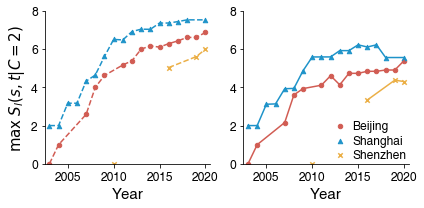

In [86]:
pd_S_all = avg_S2.groupby(by=['C',
                              'snapshot',
                              'snapshot_f',
                              'k',
                              'city',
                              'Ku'],
                          as_index=False).agg({'S': np.max})
pd_S_C2 = pd_S_all[pd_S_all['C'] == '2'].copy()

fig = plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
list_color = [
    color((209, 92, 83)),
    color((30, 147, 201)),
    color((235, 175, 70))]


sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == '2') & (pd_S_C2['city'].isin(
    ['bj', 'sh']))], x='snapshot_f', y='S', hue='city', linestyle='--', palette=list_color[:2], legend=False)
sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == '2') & (pd_S_C2['city'].isin(['sz'])) & (
    pd_S_C2['snapshot_f'] > 2011)], x='snapshot_f', y='S', hue='city', linestyle='--', palette=list_color[2:], legend=False)
for i in range(len(cities)):
    city = cities[i]
    ax = plt.scatter(x=pd_S_C2[(pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == '2') & (pd_S_C2['city'] == city)]['snapshot_f'], y=pd_S_C2[(
        pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == '2') & (pd_S_C2['city'] == city)]['S'], color=list_color[i], s=20, marker=markers[i], label=city_abbr)
plt.xlim(2002.5, 2020.5)
plt.ylim(0, 8)
ax = plt.gca()
ax.set_xticks([2005., 2010., 2015., 2020, ])
plt.gca().get_xlim()
plt.tick_params(labelsize=12)
plt.ylabel(r'$\max$ ${S_l(s,t| C=2)}$', fontdict={"fontsize": 15})

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(labelsize=12)
plt.xlabel('Year', fontdict={"fontsize": 15})


plt.subplot(1, 2, 2)
cities = ['bj', 'sh', 'sz']
list_k = ['9', '14', '6']
for i in range(len(cities)):
    city = cities[i]

    for k in [list_k[i]]:

        if(city == 'sz'):
            sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2') & (
                pd_S_C2['snapshot_f'] > 2011)], x='snapshot_f', y='S', color=list_color[i])
            ax = plt.scatter(x=pd_S_C2[(pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2') & (pd_S_C2['snapshot_f'] > 2011)]['snapshot_f'], y=pd_S_C2[(
                pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2') & (pd_S_C2['snapshot_f'] > 2011)]['S'], color=list_color[i], s=20, marker=markers[i])

            ax = plt.scatter(x=pd_S_C2[(pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2') & (pd_S_C2['snapshot_f'] == 2010)]['snapshot_f'], y=pd_S_C2[(
                pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2') & (pd_S_C2['snapshot_f'] == 2010)]['S'], color=list_color[i], s=20, marker=markers[i], label=city)
        else:
            sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == k) & (
                pd_S_C2['C'] == '2')], x='snapshot_f', y='S', color=list_color[i])
            ax = plt.scatter(
                x=pd_S_C2[(pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2')]['snapshot_f'], y=pd_S_C2[(
                    pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2')]['S'], color=list_color[i]  # 'black'
                , s=20, marker=markers[i], label=city

            )


plt.xlim(2002.5, 2020.5)
plt.ylim(0, 8)
ax = plt.gca()
ax.set_xticks([2005., 2010., 2015., 2020, ])
plt.gca().get_xlim()
plt.xlabel('Year', fontdict={"fontsize": 15})
plt.tick_params(labelsize=12)
plt.ylabel(r'$\overline{S}_l(s,t)$', fontdict={"fontsize": 15})


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel(None)
plt.tick_params(labelsize=12)
plt.xlabel('Year', fontdict={"fontsize": 15})

ax = plt.gca()
plt.legend()
h, l = ax.get_legend_handles_labels()
l = ['Beijing', 'Shanghai', 'Shenzhen']
plt.legend(
    h,
    l,
    borderaxespad=0.2,
    frameon=False,
    handlelength=0.5,
    labelspacing=0.2,
    borderpad=0,
    fontsize=12,
    loc='lower right')


plt.tight_layout()


picname = 'pic_timeline/Slmax_year_cities'
# plt.savefig(picname+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')


bj 9
coefficient of determination(𝑅²) : 0.9751
intercept: [0.28059793]
slope: [[0.72703176]]
sh 14
coefficient of determination(𝑅²) : 0.9711
intercept: [0.73818545]
slope: [[0.71503011]]
sz 6
coefficient of determination(𝑅²) : 0.9845
intercept: [-0.02868302]
slope: [[0.72937301]]


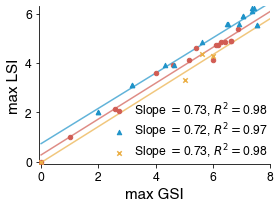

In [87]:
fig = plt.figure(figsize=(4, 3))
list_slopes = []
list_R2 = []
for i in range(len(cities)):
    city = cities[i]
    max_S2 = avg_S2.groupby(by=['C',
                                'snapshot',
                                'snapshot_f',
                                'k',
                                'city'],
                            as_index=False).agg({'S': np.max})
    max_S2 = max_S2[max_S2['city'] == city]

    for C in ['2']:
        k = list_k[i]

        model = LinearRegression()
        model = model.fit(max_S2[(max_S2['C'] == C) & (max_S2['k'] == '∞')]['S'].values.reshape(
            (-1, 1)), max_S2[(max_S2['C'] == C) & (max_S2['k'] == list_k[i])]['S'].values.reshape((-1, 1)))
        # LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
        '''get result
        y = b0 + b1x
        '''
        r_sq = model.score(max_S2[(max_S2['C'] == C) & (max_S2['k'] == '∞')]['S'].values.reshape(
            (-1, 1)), max_S2[(max_S2['C'] == C) & (max_S2['k'] == list_k[i])]['S'].values.reshape((-1, 1)))
        print(city, k)
        print('coefficient of determination(𝑅²) : %.4f' % r_sq)
        # coefficient of determination(𝑅²) : 0.715875613747954
        print('intercept:', model.intercept_)
        # b0 intercept: 5.633333333333329 -------this will be an array when y
        # is also 2-dimensional
        print('slope:', model.coef_)
        list_slopes.append(model.coef_[0][0])
        list_R2.append(r_sq)

    x = np.arange(0, 10)
    y = model.intercept_[0] + model.coef_[0][0] * x
    plt.plot(x, y, color=list_color[i]  # color((77,77,77))
             , alpha=0.7
             )

    ax = plt.scatter(
        x=max_S2[(max_S2['C'] == C) & (max_S2['k'] == '∞')]['S'], y=max_S2[(
            max_S2['C'] == C) & (max_S2['k'] == list_k[i])]['S'], color=list_color[i]  # 'black'
        , s=20, marker=markers[i], label=city_abbr, zorder=5
    )
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.tick_params(labelsize=12)
plt.xlim(-0.08, 8)
plt.ylim(-0.08, 6.3)
plt.ylabel('max LSI', size=15)
plt.xlabel('max GSI', fontdict={"fontsize": 15})

h, l = ax.get_legend_handles_labels()
l = ['Beijing',
     'Shanghai',
     'Shenzhen']
for i in range(len(l)):
    l[i] = ' Slope $= $%.2f, $R^2=$%.2f ' % (list_slopes[i], list_R2[i])
plt.legend(
    h,
    l,
    frameon=False,
    columnspacing=0.1,
    labelspacing=0.1,
    borderaxespad=0,
    handletextpad=0,
    borderpad=0.2,
    fontsize=12,
    loc='lower right')

plt.tight_layout()
picname = 'pic_timeline/GSI_LSI_cities'
# plt.savefig(picname+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')


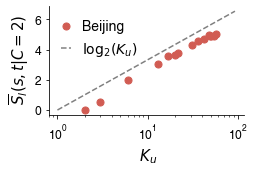

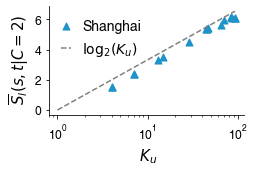

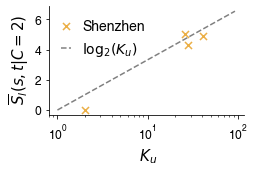

In [88]:
pd_S_all = avg_S2.groupby(by=['C',
                              'snapshot',
                              'snapshot_f',
                              'k',
                              'city',
                              'Ku'],
                          as_index=False).agg({'S': np.average})
pd_S_C2 = pd_S_all[pd_S_all['C'] == '2'].copy()
cities_name = ['Beijing', 'Shanghai', 'Shenzhen']


for i in range(len(cities)):
    fig = plt.figure(figsize=(3.5, 2))
    city = cities[i]
    ax = plt.scatter(x=pd_S_C2[(pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == '2') & (pd_S_C2['city'] == city)]['Ku'], y=pd_S_C2[(pd_S_C2['k'] == '∞') & (
        pd_S_C2['C'] == '2') & (pd_S_C2['city'] == city)]['S'], color=list_color[i], s=50, marker=markers[i], label=cities_name[i])

    plt.xscale('log')
    kt = np.linspace(1, pd_S_C2['Ku'].max() + 1, 20)
    plt.plot(kt, np.log2(kt), '--', color='gray', label=r'$\log_2(K_u)$')
    plt.legend(frameon=False, fontsize=12)
    plt.ylabel(r' ${\overline{S}_l(s,t|C=2)}$', fontdict={"fontsize": 15})
    plt.xlabel(' ${K_{u}}$', fontdict={"fontsize": 15})

    ax = plt.gca()
    h, l = ax.get_legend_handles_labels()
    plt.legend([h[1], h[0]], [l[1], l[0]], frameon=False,
               handlelength=0.7, labelspacing=0.5, fontsize=14, loc='upper left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(labelsize=12)

    picname = 'pic_timeline/Sl_Ku_' + city
#     plt.savefig(picname+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
#     plt.savefig(picname+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')


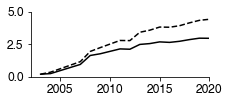

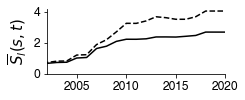

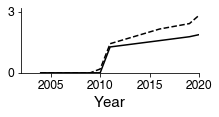

In [89]:
pd_S_all = avg_S2.groupby(by=['C',
                              'snapshot',
                              'snapshot_f',
                              'k',
                              'city',
                              'Ku'],
                          as_index=False).agg({'S': np.average})

pd_S_C2 = pd_S_all[pd_S_all['C'] == 'all'].copy()

cities = ['bj', 'sh', 'sz']
list_k = ['9', '14', '6']
for i in range(len(cities)):
    city = cities[i]

    plt.figure(figsize=(3.2, 1.2))
    list_color = [
        color((209, 92, 83)),
        color((30, 147, 201)),
        color((235, 175, 70))]
    sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == 'all') & (
        pd_S_C2['city'] == city)], x='snapshot_f', y='S', linestyle='--', color='black')

    for k in [list_k[i]]:
        sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == k) & (
            pd_S_C2['C'] == 'all')], x='snapshot_f', y='S', color='black')

    ax = plt.gca()
    ylims = [(0, 5), (0, 4.2), (0, 3.2)]
    yticks = [[0, 2.5, 5], [0, 2, 4], [0, 3]]
    plt.ylim(ylims[i])
    ax.set_yticks(yticks[i])
    plt.ylabel(None)

    plt.xlim(2002, 2020)
    plt.gca().get_xlim()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.tick_params(labelsize=12)

    plt.xlabel(None)
    if(city == 'sz'):
        plt.xlabel('Year', fontdict={"fontsize": 15})
    if(city == 'sh'):
        plt.ylabel(r'$\overline{S}_l(s,t)$', fontdict={"fontsize": 15})

    picname = 'pic_timeline/Sl_' + city
#     plt.savefig(picname+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
#     plt.savefig(picname+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')
    # plt.savefig(picname+'.eps',format = "eps",dpi=600,transparent = True,bbox_inches = 'tight')


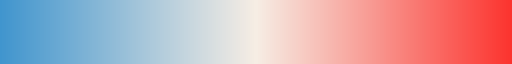

In [90]:
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(65 / 256, 247 / 256, N)
vals[:, 1] = np.linspace(150 / 256, 238 / 256, N)
vals[:, 2] = np.linspace(207 / 256, 229 / 256, N)
newcmp1 = ListedColormap(vals)

vals = np.ones((N, 4))
vals[:, 0] = np.linspace(247 / 256, 253 / 256, N)
vals[:, 1] = np.linspace(238 / 256, 52 / 256, N)
vals[:, 2] = np.linspace(229 / 256, 47 / 256, N)
newcmp2 = ListedColormap(vals)
newcmp2
newcmp = np.vstack((newcmp1(np.linspace(0, 1, 128)),
                    newcmp2(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcmp)
newcmp

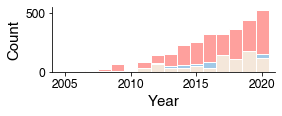

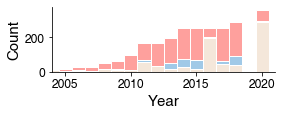

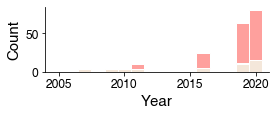

In [91]:
timelines = [
    ['2003', '2004', '2007', '2008', '2009', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
    ['2000','2003','2004','2005','2006','2007','2008','2009','2010', '2011','2012','2013','2014','2015','2016','2017','2018','2020'], 
    ['2004','2007','2009','2010','2011','2016','2019','2020']
]
cities = ['bj', 'sh', 'sz']
list_k = ['9', '14', '6']

for i in range(len(cities)):
    city = cities[i]
    timeline = timelines[i]
    pd_Sst = pd.DataFrame()

    for snapshot in timeline:
        [matrix_Ss,
         matrix_nroutes,
         matrix_pathlength,
         matrix_pathdist,
         H0,
         dualH_sub,
         dualH_nodes_sub,
         dualH_edges_sub,
         N_sub,
         N_Ktot,
         matrix_S_nid,
         matrix_S_nid_C1,
         matrix_S_nid_C2,
         matrix_S_nid_C3] = load_variable('output/GSI/' + city + '_' + snapshot + '.pkl')

        tmp_Sst = pd.concat([pd.DataFrame({
            's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
            't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
            'S':matrix_S_nid.flatten(), 'C':'all', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C1.flatten(), 'C':'1', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C2.flatten(), 'C':'2', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C3.flatten(), 'C':'3', 'snapshot':snapshot})
        ], axis=0, ignore_index=True)
        # len(set([list(dualH_sub[u][v])[0] for u,v in dualH_sub.edges()]))#
        tmp_Sst['Ktot'] = len(nx.Graph(dualH_sub).edges())
        tmp_Sst['k'] = '∞'
        pd_Sst = pd_Sst.append(tmp_Sst, ignore_index=True)
        for k in [list_k[i]]:
            [
                matrix_Ss_sub,
                matrix_nroutes_sub,
                matrix_pathlength_sub,
                matrix_pathdist_sub,
                matrix_Ktot_sub,
                matrix_S_nid,
                matrix_Ktot_st_sub,
                matrix_S_nid_C1,
                matrix_Ktot_st_C1_sub,
                matrix_S_nid_C2,
                matrix_Ktot_st_C2_sub,
                matrix_S_nid_C3,
                matrix_Ktot_st_C3_sub,
            ] = load_variable(
                'output/LSI/ksp_' +
                str(k) +
                '_' +
                city +
                '_' +
                snapshot +
                '.pkl')
            tmp_Sst = pd.concat([pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid.flatten(), 'C':'all', 'snapshot':snapshot,
                'Ktot':matrix_Ktot_st_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C1.flatten(), 'C':'1', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C1_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C2.flatten(), 'C':'2', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C2_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C3.flatten(), 'C':'3', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C3_sub.flatten()})], axis=0, ignore_index=True)

            tmp_Sst['k'] = str(k)
            pd_Sst = pd_Sst.append(tmp_Sst, ignore_index=True)

    pd_Sst = pd_Sst[(pd_Sst['S'] > -1) & (np.isnan(pd_Sst['S']) == False)]
    pd_Sst['st'] = pd_Sst['s'].astype(str) + '-' + pd_Sst['t'].astype(str)
    pd_Sst['snapshot_f'] = pd_Sst['snapshot']
    pd_Sst['snapshot_f'] = pd_Sst['snapshot_f'].astype(np.float)
    pd_Sst

    p1 = pd_Sst.merge(pd_Sst.groupby(by=['st', 'C', 's', 't', 'k'], as_index=False).agg(
        {'snapshot_f': np.min}), on=['st', 'C', 's', 't', 'k'])

    plt.figure(figsize=(4, 1.2))
    for pi in range(1, len(timeline)):

        snapshot = timeline[pi][:4]
        year = int(snapshot)
        last_year = int(timeline[pi - 1][:4])
        k = '∞'  # 7#
        idx = pi + 2

        pd_diff = p1[(p1['k'] == str(k)) & (p1['C'] == 'all') & (p1['snapshot_f_y'] < year) & (p1['snapshot_f_x'] == year)]        .merge(p1[(p1['k'] == str(
            k)) & (p1['C'] == 'all') & (p1['snapshot_f_y'] < year) & (p1['snapshot_f_x'] == last_year)], on=['s', 't', 'C', 'k', 'st', 'snapshot_f_y'])
        pd_diff['S_diff'] = pd_diff['S_x'] - pd_diff['S_y']
        pd_diff.loc[pd_diff['S_diff'] < 0, 'diff'] = '-1'
        pd_diff.loc[pd_diff['S_diff'] == 0, 'diff'] = '0'
        pd_diff.loc[pd_diff['S_diff'] > 0, 'diff'] = '1'
        hh = sns.histplot(
            data=pd_diff, x="snapshot_f_x_x", hue="diff", multiple="stack", hue_order=[
                '1', '-1', '0'], palette=[
                color(
                    (254, 129, 125)), color(
                    (129, 184, 223)), color(
                        (241, 224, 206))], edgecolor='white')
    ax = plt.gca()
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlim(2004, 2021)

    label_vals = ax.get_xticks()

    plt.tick_params(labelsize=12)
    plt.xlabel('Year', fontdict={"family": "Helvetica", "fontsize": 15})
    plt.ylabel('Count', fontdict={"family": "Helvetica", "fontsize": 15})



In [ ]:
timelines = [
    ['2003', '2004', '2007', '2008', '2009', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
    ['2000','2003','2004','2005','2006','2007','2008','2009','2010', '2011','2012','2013','2014','2015','2016','2017','2018','2020'], 
    ['2004','2007','2009','2010','2011','2016','2019','2020']
]
cities = ['bj', 'sh', 'sz']
list_k = ['9', '14', '6']

# i=2
for i in range(len(cities)):
    city = cities[i]
    timeline = timelines[i]
    pd_Sst = pd.DataFrame()

    for snapshot in timeline:
        [matrix_Ss,
         matrix_nroutes,
         matrix_pathlength,
         matrix_pathdist,
         H0,
         dualH_sub,
         dualH_nodes_sub,
         dualH_edges_sub,
         N_sub,
         N_Ktot,
         matrix_S_nid,
         matrix_S_nid_C1,
         matrix_S_nid_C2,
         matrix_S_nid_C3] = load_variable('output/GSI/' + city + '_' + snapshot + '.pkl')

        tmp_Sst = pd.concat([pd.DataFrame({
            's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
            't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
            'S':matrix_S_nid.flatten(), 'C':'all', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C1.flatten(), 'C':'1', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C2.flatten(), 'C':'2', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C3.flatten(), 'C':'3', 'snapshot':snapshot})
        ], axis=0, ignore_index=True)
        # len(set([list(dualH_sub[u][v])[0] for u,v in dualH_sub.edges()]))#
        tmp_Sst['Ktot'] = len(nx.Graph(dualH_sub).edges())
        tmp_Sst['k'] = '∞'
        pd_Sst = pd_Sst.append(tmp_Sst, ignore_index=True)
        for k in [list_k[i]]:
            [
                matrix_Ss_sub,
                matrix_nroutes_sub,
                matrix_pathlength_sub,
                matrix_pathdist_sub,
                matrix_Ktot_sub,
                matrix_S_nid,
                matrix_Ktot_st_sub,
                matrix_S_nid_C1,
                matrix_Ktot_st_C1_sub,
                matrix_S_nid_C2,
                matrix_Ktot_st_C2_sub,
                matrix_S_nid_C3,
                matrix_Ktot_st_C3_sub,
            ] = load_variable(
                'output/LSI/ksp_' +
                str(k) +
                '_' +
                city +
                '_' +
                snapshot +
                '.pkl')
            tmp_Sst = pd.concat([pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid.flatten(), 'C':'all', 'snapshot':snapshot,
                'Ktot':matrix_Ktot_st_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C1.flatten(), 'C':'1', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C1_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C2.flatten(), 'C':'2', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C2_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C3.flatten(), 'C':'3', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C3_sub.flatten()})], axis=0, ignore_index=True)

            tmp_Sst['k'] = str(k)
            pd_Sst = pd_Sst.append(tmp_Sst, ignore_index=True)

    pd_Sst = pd_Sst[(pd_Sst['S'] > -1) & (np.isnan(pd_Sst['S']) == False)]
    pd_Sst['st'] = pd_Sst['s'].astype(str) + '-' + pd_Sst['t'].astype(str)
    pd_Sst['snapshot_f'] = pd_Sst['snapshot']
    pd_Sst['snapshot_f'] = pd_Sst['snapshot_f'].astype(np.float)
    pd_Sst

    p1 = pd_Sst.merge(pd_Sst.groupby(by=['st', 'C', 's', 't', 'k'], as_index=False).agg(
        {'snapshot_f': np.min}), on=['st', 'C', 's', 't', 'k'])

    plt.figure(figsize=(4, 1.2))
    for pi in range(1, len(timeline)):

        snapshot = timeline[pi][:4]
        year = int(snapshot)
        last_year = int(timeline[pi - 1][:4])
        k = list_k[i]  # 7#
        idx = pi + 2

        pd_diff = p1[(p1['k'] == str(k)) & (p1['C'] == 'all') & (p1['snapshot_f_y'] < year) & (p1['snapshot_f_x'] == year)]        .merge(p1[(p1['k'] == str(
            k)) & (p1['C'] == 'all') & (p1['snapshot_f_y'] < year) & (p1['snapshot_f_x'] == last_year)], on=['s', 't', 'C', 'k', 'st', 'snapshot_f_y'])
        pd_diff['S_diff'] = pd_diff['S_x'] - pd_diff['S_y']
        pd_diff.loc[pd_diff['S_diff'] < 0, 'diff'] = '-1'
        pd_diff.loc[pd_diff['S_diff'] == 0, 'diff'] = '0'
        pd_diff.loc[pd_diff['S_diff'] > 0, 'diff'] = '1'
        hh = sns.histplot(
            data=pd_diff, x="snapshot_f_x_x", hue="diff", multiple="stack", hue_order=[
                '1', '-1', '0'], palette=[
                color(
                    (254, 129, 125)), color(
                    (129, 184, 223)), color(
                        (241, 224, 206))], edgecolor='white')
    ax = plt.gca()
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlim(2004, 2021)

    label_vals = ax.get_xticks()

    plt.tick_params(labelsize=12)
    plt.xlabel('Year', fontdict={"family": "Helvetica", "fontsize": 15})
    plt.ylabel('Count', fontdict={"family": "Helvetica", "fontsize": 15})
    # plt.savefig('pic_timeline_sh/deltaS_1_'+str(k)+'_0.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
    # plt.savefig('pic_timeline_sh/deltaS_1_'+str(k)+'_0.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')
    # # plt.savefig('pic_timeline/deltaS_1_'+str(k)+'.eps',dpi=600,transparent = True,bbox_inches = 'tight')
